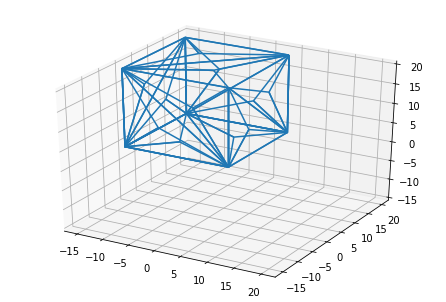

[(0, {'triangle': array([ 5., -2., 20.,  5., -2.,  0.,  5., 18.,  0.], dtype=float32)}), (1, {'triangle': array([ 5., -2., 20.,  5., 18.,  0.,  5., 18., 20.], dtype=float32)}), (2, {'triangle': array([-15.,  18.,  20., -15.,  18.,   0., -15.,  -2.,   0.],
      dtype=float32)}), (3, {'triangle': array([-15.,  18.,  20., -15.,  -2.,   0., -15.,  -2.,  20.],
      dtype=float32)}), (4, {'triangle': array([  5.,  18.,  20., -15.,  18.,  20., -15.,  -2.,  20.],
      dtype=float32)}), (5, {'triangle': array([  5.,  18.,  20., -15.,  -2.,  20.,   5.,  -2.,  20.],
      dtype=float32)}), (6, {'triangle': array([  5.,  -2.,   0., -15.,  -2.,   0., -15.,  18.,   0.],
      dtype=float32)}), (7, {'triangle': array([  5.,  -2.,   0., -15.,  18.,   0.,   5.,  18.,   0.],
      dtype=float32)}), (8, {'triangle': array([  5.,  18.,  20.,   5.,  18.,   0., -15.,  18.,   0.],
      dtype=float32)}), (9, {'triangle': array([  5.,  18.,  20., -15.,  18.,   0., -15.,  18.,  20.],
      dtype=float32)}),

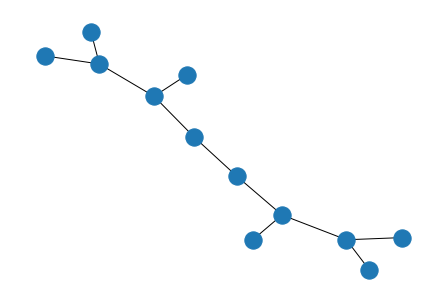

In [2]:
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import networkx as nx
import stl
from stl import mesh as m
def matchingPoint(point,triangle):
    return True if (point == triangle[:3]).all() or (point == triangle[3:6]).all() or (point == triangle[6:]).all() else False
def connection(triangle,other_triangle):
    shared =1 if matchingPoint(triangle[:3],other_triangle) else 0
    shared+=1 if matchingPoint(triangle[3:6],other_triangle) else 0
    shared+=1 if matchingPoint(triangle[6:],other_triangle) else 0
    return True if shared == 2 else False    
def connectedTriangles(triangle, mesh):
    connectedTriangles = []
    for t in mesh:
        if connection(t,triangle):
            connectedTriangles.append(t)
    return connectedTriangles
def addTriangleEdge(nodeFrom, nodeTo, graph):
    c = [x for x,y in graph.nodes(data=True) if (y['triangle']==nodeTo).all()]
    graph.add_edge(nodeFrom[0], c[0])
def center1D(a,b,c,d):
    return (a[d] + b[d] + c[d]) / 3
def findCenter(a,b,c):
    x = center1D(a,b,c,0)
    y = center1D(a,b,c,1)
    z = center1D(a,b,c,2)
    return x,y,z
def midPoint(a,b):
    return [(a[0] + b[0])/2,(a[1] + b[1])/2,(a[2] + b[2])/2]
def findMiddles(a,b,c):
    e = midPoint(a,b)
    f = midPoint(b,c)
    g = midPoint(c,a)
    return e,f,g
def toPoints(a,b,c):
    return [a[0],a[1],a[2],b[0],b[1],b[2],c[0],c[1],c[2]]
def generateTriangles(triangles):
    points = []
    for t in triangles:
        points.append(toPoints(t[0],t[1],t[2]))
    return points, triangles  
def retriangulate(triangle): 
    a,b,c = triangle[:3],triangle[3:6],triangle[6:]
    d = findCenter(a,b,c)
    e,f,g = findMiddles(a,b,c)
    return generateTriangles([[a,b,d],[a,d,c],[d,b,c]])
def createMesh(p,v):
    mesh = m.Mesh(numpy.zeros(p.shape[0],dtype=m.Mesh.dtype))
    mesh.vectors = v
    mesh.points = p
    return mesh
def plotMesh(mesh):
    figure = plt.figure()
    axes = mplot3d.Axes3D(figure,frame_on=False)
    axes.add_collection3d(mplot3d.art3d.Line3DCollection(mesh.vectors))
    scale = mesh.points.flatten()
    axes.auto_scale_xyz(scale, scale, scale)
    plt.show()
def triangulate_mesh(m):
    for i, triangle in enumerate(m.points):
        p, v = retriangulate(triangle)
        p_ = numpy.concatenate([m.points,p],)
        v_ = numpy.concatenate([m.vectors,v],)
        m = createMesh(p_,v_)
    return m
def graph_from_mesh(m):
    G = nx.Graph()
    for i, triangle in enumerate(m.points):
        G.add_node(i, triangle=triangle)
    for node in G.nodes.data():
        triangles = connectedTriangles(node[1]['triangle'],m)
        for triangle in triangles:
            addTriangleEdge(node,triangle,G)
    return G

#load the mesh
my_mesh = m.Mesh.from_file('cube.stl')

#triangulate the mesh
my_mesh2 = triangulate_mesh(my_mesh)

#plot the mesh
plotMesh(my_mesh2)

#construct graph
G = graph_from_mesh(my_mesh)
#find minimum spanning tree
T = nx.minimum_spanning_tree(G)
nx.draw(T)
print (G.nodes.data())
print (T.nodes.data())

#export STL for verification
my_mesh.save('modified-cube.stl', mode=stl.Mode.ASCII)